In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.ndimage import gaussian_filter1d


import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go

import elephant
import quantities as pq
import neo
import viziphant


from drn_interactions.spikes import SpikesHandler
from drn_interactions.load import load_derived_generic, load_neurons

<AxesSubplot:xlabel='session_name'>

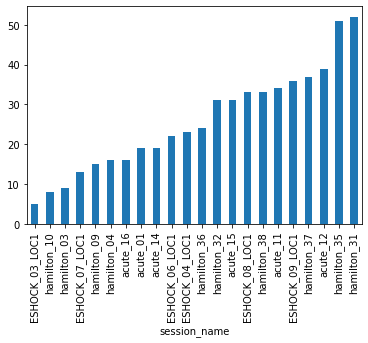

In [2]:
neurons = load_neurons()
neurons.groupby("session_name").apply(len).sort_values().plot(kind="bar")

In [193]:
t_start= 140
t_stop = t_start + 20
session_name = "hamilton_31"
bin_width = 0.03

sh = SpikesHandler(block="base_shock", bin_width=bin_width, session_names=[session_name], t_stop=t_stop, t_start=t_start)
spiketrains = [
    neo.SpikeTrain(
        group["spiketimes"].values, 
        t_stop=t_stop, 
        units=pq.sec, 
        description=name,
        t_start=t_start
    ) 
    for name, group in sh.spikes.groupby("neuron_id")
    ]


c:\Users\roryl\.conda\envs\drn-interactions\lib\site-packages\elephant\utils.py:290: UserWarning:

Correcting 1 rounding errors by shifting the affected spikes into the following bin. You can set tolerance=None to disable this behaviour.

c:\Users\roryl\.conda\envs\drn-interactions\lib\site-packages\elephant\conversion.py:1169: UserWarning:

Binning discarded 5 last spike(s) of the input spiketrain



compute rates by boxcar-kernel convolution...
compute the prob. that each neuron fires in each pair of bins...
compute the probability matrix by Le Cam's approximation...
substitute 0.5 to elements along the main diagonal...


<AxesSubplot:>

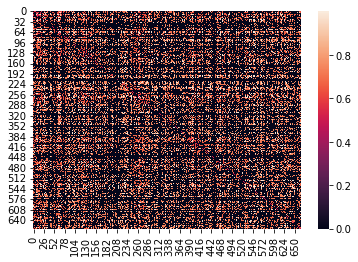

In [194]:
asset = elephant.asset.ASSET(spiketrains, bin_size= bin_width * pq.sec)
imat = asset.intersection_matrix(
    # normalization="mean"
    )
pmat = asset.probability_matrix_analytical(imat, kernel_width=1 * pq.sec)
sns.heatmap(pmat)

Available OpenCL devices:
 [<pyopencl.Device 'NVIDIA GeForce GTX 1070' on 'NVIDIA CUDA' at 0x240aed77370>]
[Joint prob. matrix] it_todo=201, grid_size=59, L_BLOCK=64, N_THREADS=64


<AxesSubplot:>

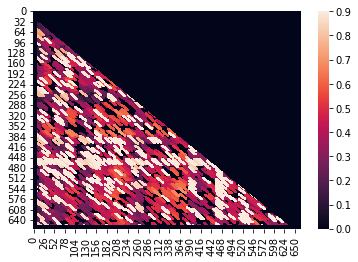

In [195]:
jmat = asset.joint_probability_matrix(
    pmat, 
    filter_shape=(21, 5),
    n_largest=1,
    )
sns.heatmap(jmat, vmax=0.9)

In [196]:
mmat = asset.mask_matrices([pmat, jmat], thresholds=(0.9, 0.99))
mmat = np.where(imat > 1, mmat, 0)
# sns.heatmap(mmat)

In [197]:
cmat = asset.cluster_matrix_entries(
    mmat, 
    max_distance=15,
    min_neighbors=5,
    stretch=2,
    )
    
# sns.heatmap(cmat,  vmin=0, cmap="seismic")

In [198]:
sses =asset.extract_synchronous_events(cmat)
print(len(sses))

37


c:\Users\roryl\.conda\envs\drn-interactions\lib\site-packages\elephant\utils.py:290: UserWarning:

Correcting 1 rounding errors by shifting the affected spikes into the following bin. You can set tolerance=None to disable this behaviour.

c:\Users\roryl\.conda\envs\drn-interactions\lib\site-packages\elephant\conversion.py:1169: UserWarning:

Binning discarded 5 last spike(s) of the input spiketrain



In [199]:
# list(sses[cluster_id].keys())

time = list(zip(*sses[2].keys()))
event_min = min(min(time))
event_max = max(max(time))

# bins[::-1]event_min]
# bins[event_max]
# bins = np.arange(t_start, t_stop, bin_width)


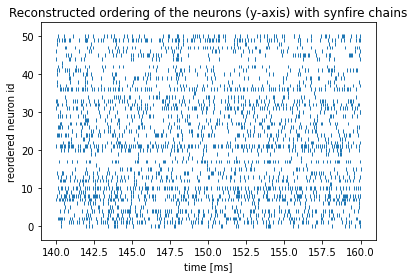

In [200]:
cluster_id = 1
cluster_chain = []
for chain in sses[cluster_id].values():
    cluster_chain.extend(chain)

_, st_indices = np.unique(cluster_chain, return_index=True)
st_indices = np.take(cluster_chain, np.sort(st_indices))

reordered_sts = [spiketrains[idx] for idx in st_indices]
spiketrains_not_a_pattern = [spiketrains[idx] for idx in range(len(spiketrains))
                      if idx not in st_indices]
reordered_sts.extend(spiketrains_not_a_pattern)

plt.figure()
plt.eventplot([st.magnitude for st in reordered_sts], linewidths=1, linelengths=1)
plt.xlabel('time [ms]')
plt.ylabel('reordered neuron id')
plt.title('Reconstructed ordering of the neurons (y-axis) with synfire chains');

In [201]:
bins = np.arange(t_start, t_stop, bin_width)


c:\users\roryl\repos\spiketimes\spiketimes\plots.py:95: UserWarning:

A spiketrain with no spikes in the plotting window was passed, skipping.



<Figure size 432x288 with 0 Axes>

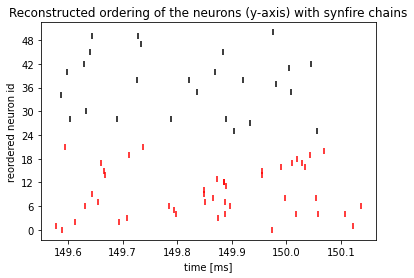

In [202]:
cluster_id = 5
cluster_times = []
for chain in sses[cluster_id].keys():
    cluster_times.append(bins[int(max(chain))])

cluster_min, cluster_max = min(cluster_times), max(cluster_times)

cluster_chain = []
for chain in sses[cluster_id].values():
    cluster_chain.extend(chain)

_, st_indices = np.unique(cluster_chain, return_index=True)
st_indices = np.take(cluster_chain, np.sort(st_indices))

reordered_sts = [spiketrains[idx].magnitude for idx in st_indices]
reordered_sts = [st[(st > cluster_min) & (st < cluster_max)] for st in reordered_sts]


spiketrains_not_a_pattern = [spiketrains[idx].magnitude for idx in range(len(spiketrains))
                      if idx not in st_indices]

spiketrains_not_a_pattern = [st[(st > cluster_min) & (st < cluster_max)] for st in spiketrains_not_a_pattern]
             

st_lists = []

plt.figure()
# plt.eventplot([st.magnitude for st in reordered_sts], linewidths=1, linelengths=1)

grouped_raster(
    st_lists=[reordered_sts, spiketrains_not_a_pattern], color_list=["red", "black"]
)
plt.xlabel('time [ms]')
plt.ylabel('reordered neuron id')
plt.title('Reconstructed ordering of the neurons (y-axis) with synfire chains');

In [135]:
from spiketimes.plots import grouped_raster

In [136]:
?grouped_raster

Signature:
grouped_raster(
    st_lists:list,
    color_list:list=None,
    ax=None,
    skip_empty=True,
    t_start:float=None,
    t_stop:float=None,
    plot_kwargs=None,
    space_between_groups:int=2,
)
Docstring:
Construct a raster plot of multiple groups of spiketrains.

Args:
    st_lists: A list of lists of spiketrains. Each sublist contains one group of spiketrains.
    color_list: A list containing one color for each group to be plotted/
    ax: A matplotlib axes object
    skip_empty: Whether to skip spiketrains with no spikes in the plotting interval 
    t_start: Minimum timepoint
    t_stop: Maximum timepoint
    plot_kwargs: Additional key-word arguments will be passed into matplotlib.pyplot.plot
    space_between_groups: Number of spaces between groups in the y direction.
Returns:
    A matloblib axes object
File:      c:\users\roryl\repos\spiketimes\spiketimes\plots.py
Type:      function


In [87]:
# for each one, what was the start, what was the end, which neurons were involved. in what order were they?

# for name in sses.keys():
    
time = list(zip(*sses[2].keys()))

event_min = min(min(time))
event_max = max(max(time))

bins[event_min]
bins[event_max]

event_neurons_idx = []
for neurons in sses[cluster_id].values():
    event_neurons_idx.extend(neurons)

neuron_ids = [st.description for st in spiketrains]
event_ids = [neuron_ids[id] for id in event_neurons_idx]



spiketrains_not_a_pattern = [
    spiketrains[idx] for idx in range(len(spiketrains))
        if idx not in st_indices]



In [88]:
dfp = pd.DataFrame([{"neuron_id": st.description, "spiketimes": st.magnitude} for st in spiketrains]).explode("spiketimes").assign(spiketimes = lambda x: x.spiketimes.astype(float))

dfp["state"] = np.where(
    (dfp["spiketimes"] > bins[event_min]) & (dfp["spiketimes"] < bins[event_max]) & (dfp["neuron_id"].isin(event_ids)),
    1, 0
    )


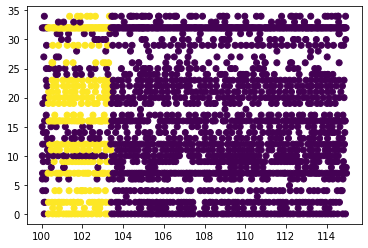

In [89]:
for i, (id, group) in enumerate(dfp.groupby("neuron_id")):
    plt.scatter(x=group["spiketimes"], y=np.ones(len(group["spiketimes"])) * i, c=group["state"])


In [73]:
bins[event_min]

100.84999999999995

In [191]:
time = np.arange(t_start, t_stop, bin_size)

Wall time: 0 ns


In [180]:
pd.DataFrame(cmat).reset_index().melt(id_vars="index").rename(columns={"index": "start", "variable": "stop"})

,start,stop,value
0,0,0,0
1,1,0,0
2,2,0,0
3,3,0,0
4,4,0,0
...,...,...,...
999995,995,999,0
999996,996,999,0
999997,997,999,0
999998,998,999,0


In [177]:
cmat.shape

(1000, 1000)

In [149]:
cluster_id = 1
cluster_chain = []
for chain in sses[cluster_id].values():
    cluster_chain.extend(chain)

_, st_indices = np.unique(cluster_chain, return_index=True)

In [163]:
# cluster_chain

In [161]:
np.unique(cluster_chain, return_index=True)

(array([ 0,  2,  5,  7,  8, 10, 11, 14, 15, 17, 18]),
 array([ 3, 35, 38,  1, 17, 34,  0,  8, 33,  4,  2], dtype=int64))

In [164]:
np.take(cluster_chain, np.sort(st_indices))

array([11,  7, 18,  0, 17, 14,  8, 15, 10,  2,  5])

In [160]:
event_id = 1
time = np.arange(t_start, t_stop, bin_size)


for event_idx, ((time_start, time_stop), neuron_index) in enumerate(sses[event_id].items()):



{(63, 24): {11},
 (72, 35): {7},
 (74, 36): {18},
 (78, 41): {0, 17},
 (95, 60): {0},
 (101, 64): {18},
 (103, 64): {14, 18},
 (108, 67): {17},
 (118, 74): {18},
 (219, 176): {18},
 (221, 184): {14},
 (226, 184): {14},
 (227, 185): {18},
 (227, 186): {11},
 (227, 189): {18},
 (227, 190): {8},
 (229, 184): {17},
 (233, 193): {14},
 (235, 193): {14},
 (236, 189): {18},
 (236, 195): {18},
 (238, 195): {18},
 (239, 193): {14},
 (239, 202): {14},
 (244, 202): {18},
 (244, 206): {18},
 (252, 206): {18},
 (252, 208): {18},
 (252, 210): {18},
 (430, 386): {0},
 (437, 391): {11},
 (437, 392): {15},
 (439, 398): {10},
 (441, 397): {2},
 (442, 395): {18},
 (442, 398): {5, 18},
 (442, 402): {18},
 (444, 395): {18},
 (444, 398): {10, 18},
 (444, 402): {18},
 (452, 402): {18},
 (457, 413): {2}}

In [152]:
np.unique(cluster_chain, return_index=True)

(array([ 0,  2,  5,  7,  8, 10, 11, 14, 15, 17, 18]),
 array([ 3, 35, 38,  1, 17, 34,  0,  8, 33,  4,  2], dtype=int64))

In [150]:
cluster_chain

[11,
 7,
 18,
 0,
 17,
 0,
 18,
 18,
 14,
 17,
 18,
 18,
 14,
 14,
 18,
 11,
 18,
 8,
 17,
 14,
 14,
 18,
 18,
 18,
 14,
 14,
 18,
 18,
 18,
 18,
 18,
 0,
 11,
 15,
 10,
 2,
 18,
 18,
 5,
 18,
 18,
 10,
 18,
 18,
 18,
 2]

In [141]:
t_start= 0
t_stop = t_start + 5
bin_size = 0.01
session_name = "hamilton_35"

sh = SpikesHandler(block="pre", bin_width=bin_size, session_names=[session_name], t_stop=t_stop, t_start=t_start)
spiketrains = [
    neo.SpikeTrain(
        group["spiketimes"].values, 
        t_stop=t_stop, 
        units=pq.sec, 
        description=name,
        t_start=t_start
    ) 
    for name, group in sh.spikes.groupby("neuron_id")
    ]


c:\Users\roryl\.conda\envs\drn-interactions\lib\site-packages\elephant\utils.py:290: UserWarning:

Correcting 1 rounding errors by shifting the affected spikes into the following bin. You can set tolerance=None to disable this behaviour.



compute rates by boxcar-kernel convolution...
compute the prob. that each neuron fires in each pair of bins...
compute the probability matrix by Le Cam's approximation...
substitute 0.5 to elements along the main diagonal...


<AxesSubplot:>

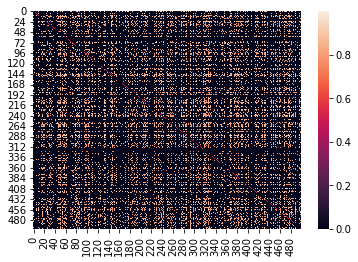

In [142]:
asset = elephant.asset.ASSET(spiketrains, bin_size= bin_size * pq.sec)
imat = asset.intersection_matrix(
    # normalization="intersection"
    )
pmat = asset.probability_matrix_analytical(imat, kernel_width= (bin_size * 10) * pq.sec)
sns.heatmap(pmat)

In [143]:
jmat = asset.joint_probability_matrix(
    pmat, 
    filter_shape=(5, 1),
    n_largest=10
    )
sns.heatmap(jmat)

Available OpenCL devices:
 [<pyopencl.Device 'NVIDIA GeForce GTX 1070' on 'NVIDIA CUDA' at 0x200b24990d0>]
[Joint prob. matrix] it_todo=53993940, grid_size=25240, L_BLOCK=64, N_THREADS=64


<AxesSubplot:>

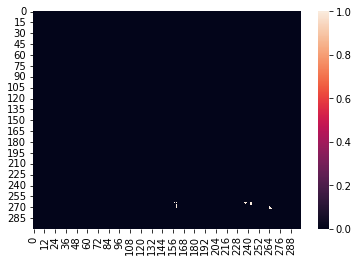

In [119]:
mmat = asset.mask_matrices([pmat, jmat], thresholds=(0.80, 0.90))
sns.heatmap(mmat)

<AxesSubplot:>

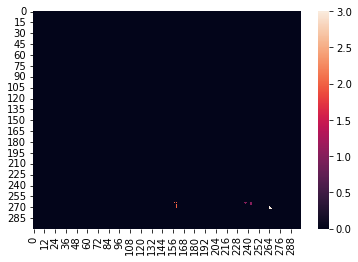

In [120]:
cmat = asset.cluster_matrix_entries(
    mmat, 
    max_distance=8,
    min_neighbors=5,
    stretch=3,
    )
sns.heatmap(cmat,  vmin=0)

In [121]:
sses =asset.extract_synchronous_events(cmat)

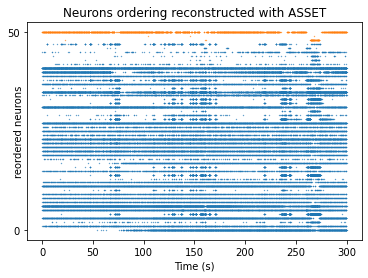

In [122]:
viziphant.asset.plot_synchronous_events(spiketrains, sse=sses[1], s=0.1)
plt.show()

Text(0.5, 1.0, 'Reconstructed ordering of the neurons (y-axis) with synfire chains')

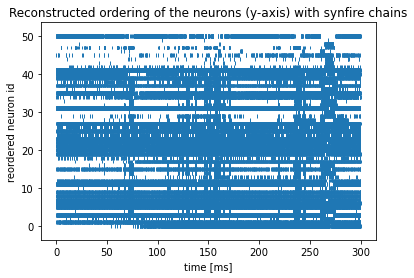

In [123]:
cluster_id = 1
cluster_chain = []
for chain in sses[cluster_id].values():
    cluster_chain.extend(chain)

_, st_indices = np.unique(cluster_chain, return_index=True)
st_indices = np.take(cluster_chain, np.sort(st_indices))
reordered_sts = [spiketrains[idx] for idx in st_indices]
spiketrains_not_a_pattern = [spiketrains[idx] for idx in range(len(spiketrains))
                      if idx not in st_indices]
reordered_sts.extend(spiketrains_not_a_pattern)

plt.figure()
# for st in reordered_sts:
    
plt.eventplot([st.magnitude for st in reordered_sts], linewidths=1, linelengths=1)
plt.xlabel('time [ms]')
plt.ylabel('reordered neuron id')
plt.title('Reconstructed ordering of the neurons (y-axis) with synfire chains')

In [124]:
time = np.arange(t_start, t_stop, bin_size)

sses

{1: {(262, 236): {0,
   1,
   2,
   3,
   4,
   5,
   6,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   25,
   26,
   27,
   28,
   29,
   30,
   31,
   33,
   35,
   36,
   37,
   38,
   39,
   41,
   42,
   45,
   46,
   47,
   48,
   49},
  (262, 238): {0,
   1,
   2,
   3,
   4,
   5,
   6,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   20,
   21,
   22,
   25,
   26,
   27,
   28,
   29,
   30,
   31,
   33,
   35,
   36,
   37,
   38,
   39,
   41,
   42,
   45,
   46,
   47,
   48,
   49},
  (264, 237): {0,
   1,
   2,
   3,
   4,
   5,
   6,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   20,
   21,
   22,
   24,
   25,
   26,
   27,
   28,
   29,
   30,
   31,
   33,
   36,
   37,
   38,
   39,
   41,
   42,
   45,
   46,
   47,
   48,
   49},
  (264, 238): {0,
   1,
   2,
   3,
   4,
   5,
   6,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
  

In [150]:
sses[1]

{(30, 10): {10, 17, 20, 23},
 (30, 13): {10, 17, 18, 20, 23},
 (32, 13): {10, 11, 18, 20},
 (33, 13): {12, 18, 20, 23},
 (34, 10): {10, 17},
 (34, 13): {10, 11, 17, 18},
 (34, 15): {1, 7, 10, 14},
 (34, 21): {1, 10},
 (34, 22): {10, 24},
 (34, 24): {10, 14},
 (34, 25): {1, 10, 17},
 (35, 26): {18, 20, 27},
 (36, 25): {0, 10, 15, 17, 22},
 (36, 27): {8, 10, 17, 19, 21},
 (37, 13): {4, 10, 11, 12, 20, 23},
 (37, 24): {4, 10, 20, 23, 27},
 (37, 27): {10, 19, 21, 23},
 (37, 28): {4, 10, 19, 20, 21},
 (38, 27): {19, 21},
 (38, 28): {18, 19, 21, 24},
 (38, 29): {0, 19, 21},
 (39, 12): {5, 15, 20, 26},
 (39, 15): {1, 7, 10, 20, 26},
 (39, 16): {5, 10, 15, 27},
 (39, 25): {1, 5, 10, 15, 26},
 (39, 28): {10, 20, 21},
 (39, 29): {1, 15, 21, 26},
 (39, 30): {7, 10, 16, 20, 21},
 (40, 30): {7, 16, 17, 20, 21, 23},
 (40, 31): {7, 16, 21, 25},
 (41, 27): {10, 21},
 (41, 28): {10, 20, 21},
 (41, 29): {21},
 (41, 30): {10, 13, 16, 20, 21},
 (41, 31): {10, 13, 16, 21},
 (41, 32): {10, 13, 16, 20, 21},
